In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from pathlib import Path 
from datetime import datetime
from adjustText import adjust_text
from cartopy.feature import NaturalEarthFeature
from matplotlib.colors import LinearSegmentedColormap
from pyschism.mesh import Hgrid
from stormevents import StormEvent
from searvey.coops import coops_stations_within_region
from shapely.geometry import MultiPolygon
from shapely.ops import polygonize

In [2]:
def format_datetime_for_coops(storm_datetime):
    return datetime(storm_datetime.year, storm_datetime.month, storm_datetime.day, storm_datetime.hour, storm_datetime.minute)

In [3]:
def get_storm_track_date(storm_track, advisory):
    for idx in storm_track.linestrings[advisory]:
        storm_track_date = idx
    return storm_track_date

In [4]:
def get_dry_node_indices(hgrid, max_elev_1, max_elev_2, bbox_str):

    """Return dry index"""
    
    # Split the string into a list of substrings using comma as the delimiter
    tmp = bbox_str.split(',')

    # Convert the substrings to floats
    lon_min = float(tmp[0])
    lat_min = float(tmp[1])
    lon_max = float(tmp[2])
    lat_max = float(tmp[3])

    h = -hgrid.values
    D1 = max_elev_1.values
    D2 = max_elev_2.values

    nodes = len(D1)
    dry_indices = np.zeros(nodes) + 1
    idxs = np.where((D1+h > 0.01) 
                    & (D2+h > 0.01) 
                    & (hgrid.x < lon_max) 
                    & (hgrid.x > lon_min) 
                    & (hgrid.y < lat_max) 
                    & (hgrid.y > lat_min) 
                    & (h < 25.0))
    dry_indices[idxs] = 0     

    return dry_indices

In [5]:
def plot_contour_diff(storm_track, domain_stations, hgrid, max_elev_1, max_elev_2, dry_indices, bbox_str, **kwargs):

    """plot maxelev diff: model2 - model1"""
    
    storm_track_date = get_storm_track_date(storm_track, 'BEST')
    
    DPI = kwargs.get('DPI', None)
    title_string = kwargs.get('title_string', None)
    calculate_mean = kwargs.get('calculate_mean', None)
    save_file_name = kwargs.get('save_file_name', None)

    # Figure dpi resolution:
    if DPI is None:       DPI = 300

    # Split the string into a list of substrings using comma as the delimiter
    tmp = bbox_str.split(',')

    # Convert the substrings to floats
    lon_min = float(tmp[0])
    lat_min = float(tmp[1])
    lon_max = float(tmp[2])
    lat_max = float(tmp[3])

    gdf_countries = gpd.GeoSeries(NaturalEarthFeature(category='physical', 
                    scale='10m', name='land').geometries(), crs=4326)

    #
    h = -hgrid.values
    D1 = max_elev_1.values
    D2 = max_elev_2.values

    # Define the colors for positive and negative values
    positive_color = 'red'
    negative_color = 'blue'

    # Create a colormap with red for positive and blue for negative values
    cmap = LinearSegmentedColormap.from_list('red_blue_colormap', 
                                             [negative_color, 'white', positive_color])

    step = 0.025 # m
    MinVal = -1.0 
    MaxVal = 1.0 
    levels = np.arange(MinVal, MaxVal + step, step=step)
    tri = hgrid.triangulation
    mask = np.any(np.where(dry_indices[tri.triangles], True, False), axis=1)
    tri.set_mask(mask)

    figure, axis = plt.subplots(1, 1)
    figure.set_size_inches(12, 12/1.6)

    contour = axis.tricontourf(
                tri,
                D2-D1,
                vmin=MinVal,
                vmax=MaxVal,
                levels=levels,
                cmap=cmap,
                extend='both')

    gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
    
    axis.plot(*storm_track.linestrings['BEST'][storm_track_date].xy, 
              c='black', linestyle ='dashed', label='BEST track')
    
    domain_stations.plot(marker='s', facecolors='none', edgecolor='black', ax=axis)

    # Label stations on the map
    labels = [axis.annotate(label, 
                            xy=(x, y), 
                            xytext=(2,2), 
                            textcoords="offset points"
                           ) 
              for x, y, label in zip(domain_stations.geometry.x, 
                                     domain_stations.geometry.y, 
                                     domain_stations.name)]

    # adjust_text(labels)  # adjust labels if needed

    xlim = [lon_min, lon_max]
    ylim = [lat_min, lat_max]

    axis.set_xlim(xlim)
    axis.set_ylim(ylim)

    plt.colorbar(contour)

    if title_string is not None:
        axis.set_title(f'{storm_track.name} {storm_track.year} max elev difference (m): {title_string}')
    else: 
        axis.set_title(f'{storm_track.name} {storm_track.year} max elev difference (m): model2 - model1')
 
    plt.savefig(f'{storm_track.name}_{storm_track.year}_max_elev_diff.png', dpi=DPI)

In [6]:
storm_name = 'FLORENCE'
storm_year = 2018

In [7]:
bbox_str = '-81.5,31.5,-74.5,36.5'

**Obtain storm track from StormEvent**

In [ ]:
# Load storm and obtain isobars from stormevent
storm = StormEvent(storm_name, storm_year)
storm_best_track = storm.track()

In [9]:
storm_date_str = get_storm_track_date(storm_best_track, 'BEST')

**Retrive COOPS stations**

In [10]:
# define COOPS domain 
isotach_limit = 50
isotach_domain = MultiPolygon(list(polygonize(storm_best_track.wind_swaths(wind_speed=isotach_limit)['BEST'][storm_date_str].exterior)))

In [11]:
# Retrieve CO-OPS stations
domain_stations = coops_stations_within_region(region=isotach_domain)

In [12]:
# domain_stations = domain_stations.reset_index()
domain_stations = domain_stations[domain_stations.status=='active']

**Read SCHISM files**

In [ ]:
# Path to out2d.nc and hgrid.gr3 files
hgrid_path = Path('.../hgrid.gr3')
output_1_path = Path('.../out2d_1.nc')
output_2_path = Path('.../out2d_1.nc')

In [14]:
hgrid = Hgrid.open(hgrid_path, crs=4326)

In [15]:
ds_1 = xr.open_dataset(output_1_path)
ds_2 = xr.open_dataset(output_2_path)

In [16]:
max_elev_1 = ds_1['elevation'].max('time')
max_elev_2 = ds_2['elevation'].max('time')

**Plot differences**

In [17]:
# create mask
dry_indices = get_dry_node_indices(hgrid, max_elev_1, max_elev_2, bbox_str)

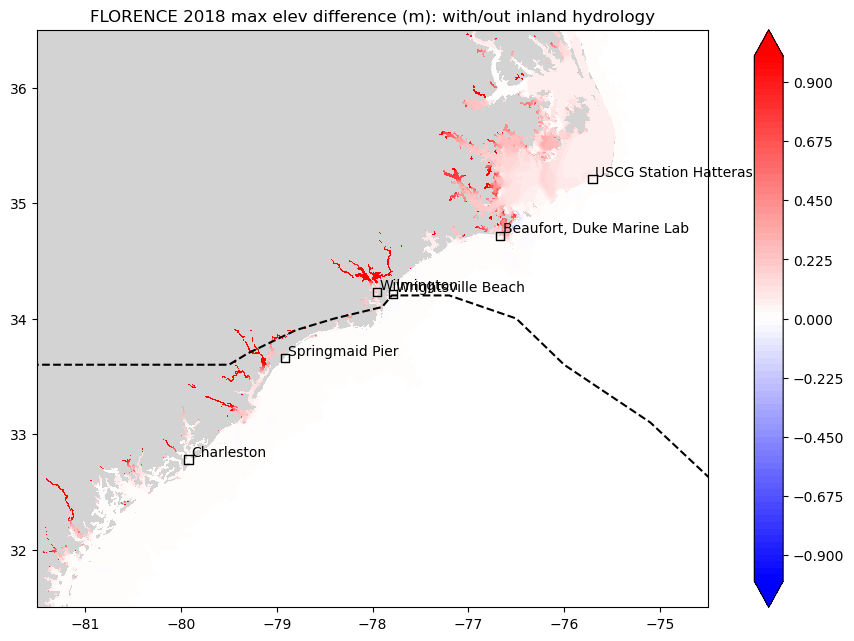

In [18]:
plot_contour_diff(storm_best_track, domain_stations,
                  hgrid, max_elev_1, max_elev_2, 
                  dry_indices, bbox_str, 
                  title_string="with/out inland hydrology")